Working through the exercises at the end of Chapter 4, "Estimating Proportions", of the 2nd edition of _Think Bayes_ by Allen Downey.

**Exercise**: In Major League Baseball, most polayers have a betting average between 200 and 330, which means that their probability of getting a hit is between 0.2 and 0.33.
Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

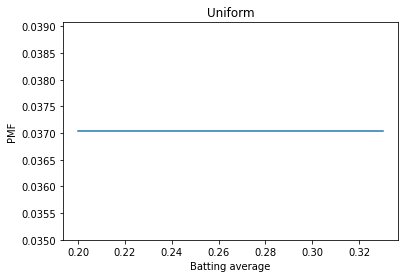

In [60]:
## At-bats in this case give a binary outcome (hit or out), so we can model using binomial Pmfs
from empiricaldist import Pmf
import numpy as np
from scipy.stats import binom
    
hypos = np.arange(start = 0.2, stop = 0.3301, step = 0.005)

## Make a uniform prior of batting averages from 200 to 330
prior = Pmf(1, hypos, name = 'prior')
prior.normalize()

prior.plot(xlabel = 'Batting average', ylabel = 'PMF', title = 'Uniform');

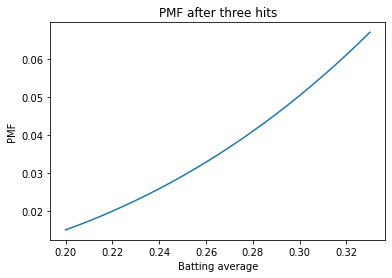

In [61]:
def update_average(pmf, data):
    """Update pmf with given data (number of hits k and number of at-bats n)."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()
    return pmf

data = 3, 3

posterior = update_average(prior, data)

##  Not surprisingly, after three straight hits, it's more likely that the 'true' batting average is on the high end

posterior.plot(xlabel = 'Batting average', ylabel = 'PMF', title = 'PMF after three hits');

**Exercise**: Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to adjust their answers to show themselves in the most positive light. one way to improve the accuracy of the results is randomized response.
As an example, suppose you want to know how many people cheat on their taxes.
If you ask them directly, it is likely that some of the cheaters will lie. You will get a more accurate estimate if you ask them indeirectly, like this: Ask each person to flip a coin and, without revealing the outcome:
* If they get heads, they report YES.
* If they get tails, they honestly answer the question "Do you cheat on your taxes?"
If someone says YES, we don't know whether they actually cheat on their taxes; they might have flipped yes. Knowing this, people might be more willing to answer honestly.
Suppose you survey 100 people this way and get 80 YESes and 20 NOs. Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes? What is the most likely quantity in the posterior distribution?

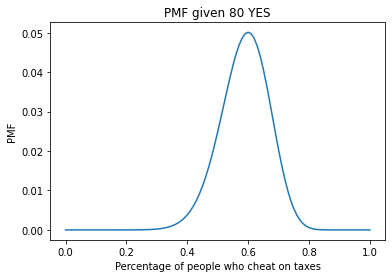

In [176]:
from empiricaldist import Pmf
import numpy as np
from scipy.stats import binom
import pandas as pd

# Say we use a uniform prior distribution

hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

def calc_probability(p, k = 80, n = 100):
    """
    Calculate probability of getting k YES answers for n people if p percentage of people cheat on taxes
    
    Keyword argument:
    p: numeric value between 0 and 1, inclusive
    k: integer between 0 and 100, inclusive
    n: integer greater than k
    """

    if p < 0 or p > 1:
        raise Exception("p must be between 0 and 1, inclusive")
    if k < 0 or k > 100:
        raise Exception("k must be integer between 0 and 100, inclusive")

    range = np.arange(k + 1)

    # Probability of getting 0 to k heads flipping a fair coin n times
    flip_ps = binom.pmf(range, n, 0.5)

    # For any p in hypos, the probability of getting k YESes is the sum (from j = 0 to k) of the
    # product P(j heads in 100 tosses) * P(k - j out of n - j people cheat on their taxes | true proportion of tax cheats is p)

    likelihoods = np.multiply(flip_ps[range], binom.pmf(k - range, n - range, p))

    l = sum(likelihoods)
    return l

likelihood = []
for p in hypos:
    l = calc_probability(p)
    likelihood += [l]

posterior = prior * likelihood

posterior.normalize()

posterior.plot(xlabel = 'Percentage of people who cheat on taxes', ylabel = 'PMF', title = 'PMF given 80 YES');


In [129]:
# The most likely value in the posterior distribution is 60%
posterior.max_prob()

# This makes sense -- given 80 YES, it's most likely that 50/100 people got heads, in which case 30 of the 50 people who answered honestly are cheating

0.6

**Exercise**: Suppose you want to test whether a coin is fair, but you don’t want to spin it hundreds of times. So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate. Specifically, suppose the probability is `y=0.2` that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of `x`? What happens as you vary the value of `y`?

Say that `x` is the chance the coin ends up heads.

Since I'd assume that the coin is probably fair, instead of a uniform prior, we'll use a triangle, say from 30% heads to 70% heads.

Given the 140 heads reported out of 250 flips, the likelihood that the true ratio of heads is `p` is the likelihood that the computer vision is off enough, in the right direction, that (true heads) / 250 = p

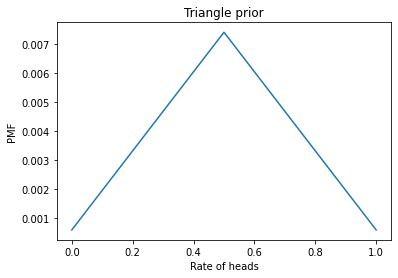

In [215]:
from empiricaldist import Pmf
import numpy as np
from scipy.stats import binom
import pandas as pd

hypos = np.arange(start = 0.0, stop = 1.001, step = 0.004)

ramp_up = np.arange(start = 1, stop = 127, step = 1)
ramp_down = np.arange(125, 0, -1)

a = np.append(ramp_up, ramp_down) + 10
# By adding 10, we're saying (roughly) that peak will be 12 times as likely as extremes

triangle = Pmf(a, np.around(hypos, 3), name = 'triangle')
triangle.normalize()
triangle.plot(xlabel = 'Rate of heads', ylabel = 'PMF', title = 'Triangle prior');

The prior distribution we've selected accounts for true rate of heads being between 0.3 and 0.7.
`0.3  250 = 75`, and `0.7 * 250 = 175`. Since the experiment showed 140 heads, we should account for up to 65 false heads and 35 false tails

0.536


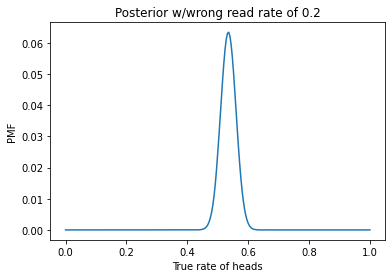

In [219]:
def update_odds_heads(p_wrong_read):
    if p_wrong_read < 0 or p_wrong_read > 1:
        raise Exception("p_wrong_read must be between 0 and 1, inclusive")

    num_false_heads = np.arange(66)
    # probability of k false heads out of 140 heads reported.
    prob_false_heads =  binom.pmf(num_false_heads, 140, p_wrong_read)

    num_false_tails = np.arange(36)
    # probability of k false tails out of 110 tails reported.
    prob_false_tails =  binom.pmf(num_false_tails, 110, p_wrong_read)

    df1 = pd.DataFrame(list(zip(num_false_heads, prob_false_heads)))
    df1.columns = ['num_false_heads', 'prob_false_heads']

    df2 = pd.DataFrame(list(zip(num_false_tails, prob_false_tails)))
    df2.columns = ['num_false_tails', 'prob_false_tails']

    df1['key'] = 1
    df2['key'] = 1

    joint_prob = pd.merge(df1, df2, on='key').drop("key", 1)
    joint_prob['true_num_heads'] = 140 - joint_prob['num_false_heads'] + joint_prob['num_false_tails']
    joint_prob['prob_outcome'] = joint_prob['prob_false_heads'] * joint_prob['prob_false_tails']

    sums = joint_prob.groupby('true_num_heads', as_index = False)['prob_outcome'].sum()
    sums['true_prob_heads'] = sums['true_num_heads'] / 250
    sums = sums.set_index('true_prob_heads')

    likelihood = Pmf(sums['prob_outcome'], np.round(sums.index.values, 3), name = 'likelihood')

    # Update to posterior based on likelihood
    posterior = triangle * likelihood
    posterior.normalize()
    return posterior

posterior = update_odds_heads(0.2)
print(posterior.max_prob())
posterior.plot(xlabel = 'True rate of heads', ylabel = 'PMF', title = 'Posterior w/wrong read rate of 0.2');

0.536


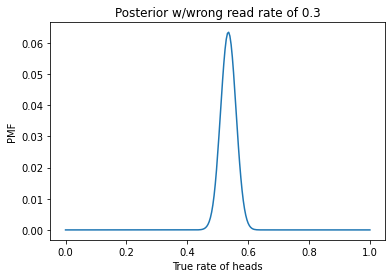

In [228]:
posterior = update_odds_heads(0.3)
print(posterior.max_prob())
posterior.plot(xlabel = 'True rate of heads', ylabel = 'PMF', title = 'Posterior w/wrong read rate of 0.3');